# DATA@FERRE FLAVIAN

### Travail sur les prix

Commençons par importer nos différentes données :

In [1]:
import pandas as pd
import math

stations = pd.read_csv("stations.csv")
providers = pd.read_csv("providers.csv")
cities = pd.read_csv("cities.csv")
ticket = pd.read_csv("ticket_data.csv")

Nous allons vérifier qu'il n'y a pas de données de prix vides (NaN) auquel cas on supprimera les lignes correspondantes :

In [2]:
ticket[pd.isnull(ticket['price_in_cents'])]

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city


Aucun prix ne manque, nous pouvons donc récupérer les données de prix minimum, moyen et maximum dans le DataFrame ticket :

In [3]:
ticket['price_in_cents'].describe()

count    74168.000000
mean      4382.711061
std       3739.325367
min        300.000000
25%       1900.000000
50%       3350.000000
75%       5250.000000
max      38550.000000
Name: price_in_cents, dtype: float64

On observe alors que :
| Prix minimum | Prix moyen | Prix maximal |
| --- | --- | --- |
| 3 € | 43,82 € | 385,5 € |

### Travail sur les durées

Nous allons vérifier qu'il n'y a pas de données concernant le départ et l'arrivée vides (NaN) auquel cas on supprimera les lignes correspondantes :

In [4]:
ticket[pd.isnull(ticket['departure_ts']) | pd.isnull(ticket['arrival_ts'])]

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city


Maintenant que cette vérification est faite, recherchons des informations sur la durée des trajets. Pour cela, il nous faut créer une colonne supplémentaire correspondant à la durée des trajets dans le DataFrame 'ticket' :

In [5]:
import datetime

# Conversion en timestamp puis soustraction
ticket['duration'] = ticket.apply(lambda x : datetime.datetime.timestamp(pd.to_datetime(x["arrival_ts"])) - datetime.datetime.timestamp(pd.to_datetime(x["departure_ts"])), axis = 1)

On vérifie bien que la durée a été ajoutée au DataFrame ticket :

In [6]:
ticket.head(5)

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,duration
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,22200.0
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,64200.0
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,115020.0
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,77700.0
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,78360.0


Maintenant, nous pouvons récupérer les valeurs qui nous intéressent.

In [7]:
ticket['duration'].describe()

count    7.416800e+04
mean     2.547725e+04
std      3.569888e+04
min      1.200000e+03
25%      1.080000e+04
50%      1.740000e+04
75%      2.880000e+04
max      1.774260e+06
Name: duration, dtype: float64

On observe alors que :
| Durée minimale | Durée moyenne | Durée maximale |
| --- | --- | --- |
| 1 200 s | 25 477 s | 1 774 260 s |
| soit 20 min | soit 7,08 h | soit 20,54 jours |

### Comparatifs train - bus - covoiturage

Réalisons un comparatif de la durée et du prix moyen en fonction du type de transport.

Commençons par concaténer les DataFrames ticket et providers pour récupérer pour chaque trajet le type de transport correspondant. On enlèvera toutes les colonnes qui ne nous serviront pas pour l'instant.

In [8]:
trajet = pd.merge(ticket, providers, left_on = ['company'], right_on = ['id'])

trajet_light = trajet.drop(['search_ts', 'middle_stations', 'other_companies', 'name', 'has_wifi', 'has_plug', 'has_adjustable_seats', 'has_bicycle', 'id_y', 'company_id', 'provider_id', 'fullname'], axis = 1)

On remarque que certaines valeurs correspondant aux stations sont nulles :

In [9]:
test = trajet_light[pd.isnull(trajet_light['o_station'])]

test['transport_type'].value_counts()

transport_type
carpooling    41441
Name: count, dtype: int64

In [10]:
trajet_light['transport_type'].value_counts()

transport_type
carpooling    41441
train         18929
bus           13798
Name: count, dtype: int64

On en déduit donc qu'il va falloir calculer la distance entre les stations pour les trains et bus, et entre les villes pour le covoiturage. Commençons par diviser notre trajet_light suivant ces deux catégories, avant de calculer les distances correspondantes à chaque trajet.

Concernant le covoiturage :

In [11]:
carpooling = trajet_light[trajet_light.transport_type == "carpooling"]

# Jointure pour le départ
carpooling = pd.merge(carpooling, cities, left_on = ['o_city'], right_on = ['id'], suffixes = ('','_o'))
carpooling.drop(['id', 'local_name', 'unique_name', 'population'], axis = 1, inplace = True)

# Jointure pour l'arrivée
carpooling = pd.merge(carpooling, cities, left_on = ['d_city'], right_on = ['id'], suffixes = ('','_d'))
carpooling.drop(['id', 'local_name', 'unique_name', 'population', 'o_station', 'd_station'], axis = 1, inplace = True)

Maintenant que nous avons joint les données de longitude et latitude nécessaires et supprimé les colonnes inutiles, il ne nous reste plus qu'à calculer la distance à vol d'oiseau entre les villes, d'après les formules issues des mathématiques :

In [12]:
carpooling['distance'] = carpooling.apply(lambda x : 6378.137 * math.acos(math.sin(math.radians(x["latitude"])) * math.sin(math.radians(x["latitude_d"])) + math.cos(math.radians(x["latitude"])) * math.cos(math.radians(x["latitude_d"])) * math.cos(math.radians(x["longitude_d"]) - math.radians(x["longitude"]))), axis = 1)
carpooling.drop(['o_city', 'd_city', 'latitude', 'longitude', 'latitude_d', 'longitude_d'], axis = 1, inplace = True)

Maintenant, nous allons répéter le même processus pour les bus et trains, en partant des stations cette fois-ci.

In [13]:
bus_trains = trajet_light[(trajet_light.transport_type == "train") | (trajet_light.transport_type == "bus")]

# Jointure pour le départ
bus_trains = pd.merge(bus_trains, stations, left_on = ['o_station'], right_on = ['id'], suffixes = ('','_o'))
bus_trains.drop(['id', 'unique_name'], axis = 1, inplace = True)

# Jointure pour l'arrivée
bus_trains = pd.merge(bus_trains, stations, left_on = ['d_station'], right_on = ['id'], suffixes = ('','_d'))
bus_trains.drop(['id', 'unique_name'], axis = 1, inplace = True)

# Calcul de distance à vol d'oiseau
bus_trains['distance'] = bus_trains.apply(lambda x : 6378.137 * math.acos(math.sin(math.radians(x["latitude"])) * math.sin(math.radians(x["latitude_d"])) + math.cos(math.radians(x["latitude"])) * math.cos(math.radians(x["latitude_d"])) * math.cos(math.radians(x["longitude_d"]) - math.radians(x["longitude"]))), axis = 1)
bus_trains.drop(['o_station', 'd_station', 'o_city', 'd_city', 'latitude', 'longitude', 'latitude_d', 'longitude_d'], axis = 1, inplace = True)

Il ne nous reste alors plus qu'à concaténer les deux DataFrames constitués pour recréer trajet_light :

In [14]:
trajet_light = pd.concat([bus_trains, carpooling])

trajet_light['transport_type'].value_counts()

transport_type
carpooling    41441
train         18929
bus           13798
Name: count, dtype: int64

In [15]:
trajet_light[pd.isnull(trajet_light['distance'])]

,id_x,company,departure_ts,arrival_ts,price_in_cents,duration,transport_type,distance


Ces vérifications nous permettent de vérifier que nous n'avons pas perdu de données et qu'il n'y a pas de ligne où la distance est nulle. Maintenant que nous avons calculé la longueur, la durée et le prix de chaque trajet répertorié dans ticket, il nous faut extraire le comparatif souhaité.

In [16]:
separates = [0, 200, 500, 800, 1200, 1800, 2000]
labels = ['<200km', '201-500km', '501-800km','800-1200km', '1200-1800km', '>1800km']
trajet_light['interval'] = pd.cut(trajet_light['distance'], bins = separates, labels = labels)

Nous allons maintenant utiliser la fonction groupby pour pouvoir regrouper les prix et durées moyennes en fonction de l'intervalle de distance et du type de transports :

In [17]:
trajet_group = trajet_light.groupby(['interval', 'transport_type']).agg({'price_in_cents' : 'mean', 'duration' : 'mean'})

trajet_group

price_in_cents       duration
interval    transport_type                               
<200km      bus                2109.564581   38847.083888
            carpooling         1177.352385    7027.342428
            train              3597.305970   15700.097015
201-500km   bus                3062.969170   45699.063019
            carpooling         2870.198445   15324.825765
            train              8188.122279   25597.334044
501-800km   bus                4214.439344   66957.088525
            carpooling         5593.100426   29589.932382
            train             11598.583031   33281.714041
800-1200km  bus                6593.014493   93808.012422
            carpooling         7797.445378   41566.386555
            train             15680.126183   43982.460568
1200-1800km bus                9444.802920  136430.802920
            carpooling        12737.500000   74900.000000
            train                      NaN            NaN
>1800km     bus               16395.000000  171000.000000
            carpooling                 NaN            NaN
            train                      NaN            NaN

Pour pouvoir conclure aisément sur le "meilleur" mode de transport, nous allons tracer des graphiques correspondant aux durées et prix moyens :

<AxesSubplot:xlabel='interval', ylabel='price_in_cents'>

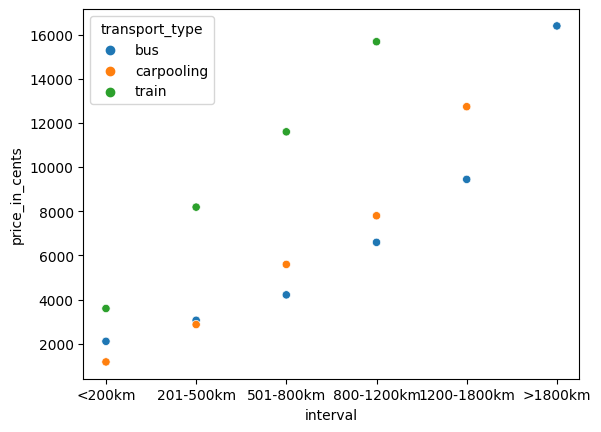

In [18]:
import seaborn as sns

sns.scatterplot(x = "interval", y = "price_in_cents", data = trajet_group, hue = "transport_type")

Avant 500km, c'est le covoiturage qui coûte le moins cher, alors qu'au-delà de 500km, le bus semble être à privilégier.

<AxesSubplot:xlabel='interval', ylabel='duration'>

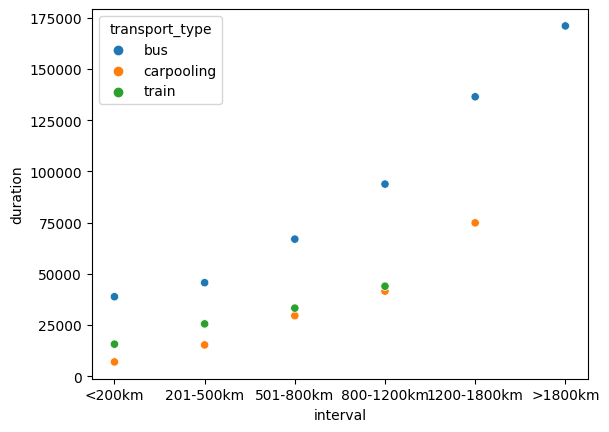

In [19]:
sns.scatterplot(x = "interval", y = "duration", data = trajet_group, hue = "transport_type")

Au niveau de la durée, c'est le covoiturage qui semble être le plus rapide en général.

En conclusion, le covoiturage semble être une bonne solution pour un bon rapport durée-prix.

### Bonus : prédiction de prix

Dans cette partie, nous allons tenter de faire un peu de Machine Learning pour construire un modèle de prédiction de prix en fonction du type de transport, de la durée et de la distance. Nous allons commencer par enlever les colonnes inutiles ici et par convertir les types de transport en entier pour pouvoir réaliser le modèle souhaité. On pensera aussi à convertir les données de temps en flottant pour réaliser cet apprentissage.

In [20]:
# Conversion des types de transport
trajet_light["transport_type"] = trajet_light["transport_type"].map({"bus" : 0, "carpooling" : 1, "train" : 2})

# Conversion en timestamp
trajet_light['departure_time'] = trajet_light.apply(lambda x : datetime.datetime.timestamp(pd.to_datetime(x['departure_ts'])), axis = 1)
trajet_light['arrival_time'] = trajet_light.apply(lambda x : datetime.datetime.timestamp(pd.to_datetime(x['arrival_ts'])), axis = 1)

trajet_light.drop(['departure_ts', 'arrival_ts', 'id_x', 'interval'], axis = 1, inplace = True)

Nous pouvons maintenant appliquer notre premier modèle de régression (puisque l'on souhaite prédire un prix), RidgeRegression :

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Décomposition entre données d'entraînement et données de test
Y = trajet_light["price_in_cents"]
X = trajet_light.drop(["price_in_cents"], axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

# Réalisation du Ridge
reg = Ridge(alpha = 1)
reg.fit(X_train, Y_train)

# Phase de prédiction du test
Y_predict = reg.predict(X_test)

# Calcul de l'efficacité de notre modèle
r2_score(Y_test, Y_predict)

0.6145446510173919

On voit donc que le R² n'est pas très élevé, puisqu'il devrait idéalement être proche de 1. Nous allons donc tenter d'améliorer notre algorithme. Pour cela, commençons par évaluer l'impact de chacun de nos coefficients :

In [22]:
reg.coef_

array([-3.34757339e-01,  3.05816420e-03,  4.07839042e+03,  9.81703323e+00,
       -1.10091943e-04,  2.49374457e-04])

Il est donc clair que les données liées au départ et à l'arrivée ne sont pas utiles ici. Nous allons les supprimer :

In [23]:
trajet_light.drop(['departure_time', 'arrival_time'], axis = 1, inplace = True)

Maintenant, tentons d'améliorer notre valeur de Alpha avec plusieurs itérations :

In [24]:
from sklearn.model_selection import GridSearchCV

# Décomposition entre données d'entraînement et données de test
Y = trajet_light["price_in_cents"]
X = trajet_light.drop(["price_in_cents"], axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

# Réalisation du Ridge
reg = Ridge()

# Choix du paramètre idéal
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 8.0, 10.0, 12.0]}
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# Valeur idéale
grid_search.best_params_

{'alpha': 0.1}

In [25]:
# Réalisation du Ridge
reg = Ridge()

# Choix du paramètre idéal
param_grid = {'alpha': [1.0, 1.5, 2.0, 2.5]}
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# Valeur idéale
grid_search.best_params_

{'alpha': 1.0}

In [26]:
# Réalisation du Ridge
reg = Ridge()

# Choix du paramètre idéal
param_grid = {'alpha': [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]}
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# Valeur idéale
grid_search.best_params_

{'alpha': 1.5}

La valeur idéale de Alpha semble être 2. Nous allons donc re-calculer notre valeur de R² avec ce nouveau paramètre :

In [27]:
# Décomposition entre données d'entraînement et données de test
Y = trajet_light["price_in_cents"]
X = trajet_light.drop(["price_in_cents"], axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

# Réalisation du Ridge
reg = Ridge(alpha = 2)
reg.fit(X_train, Y_train)

# Phase de prédiction du test
Y_predict = reg.predict(X_test)

# Calcul de l'efficacité de notre modèle
r2_score(Y_test, Y_predict)

0.617837102903189

On note alors une légère amélioration. Il existe certainement beaucoup de techniques pour améliorer cet algorithme, mais pour les besoins de ce test, j'ai préféré m'arrêter ici. Par ailleurs, le test d'autres algorithmes (SGD Regressor, Lasso et SVR) ce sont révélés infructueux, RidgeRegression étant le plus performant.

### Bonus : Rapport des soucis relevés dans les données

Dans cette partie, nous allons essayer de détailler l'ensemble des soucis qui peuvent entraîner des erreurs, des incohérences ou des complications. Regardons alors chaque DataFrame initial :

In [28]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11035 entries, 0 to 11034
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11035 non-null  int64  
 1   unique_name  11035 non-null  object 
 2   latitude     11035 non-null  float64
 3   longitude    11035 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 345.0+ KB


In [29]:
stations.describe()

,id,latitude,longitude
count,11035.000000,11035.000000,11035.000000
mean,5518.026914,47.526678,7.580807
std,3185.719813,3.953972,63.655681
min,1.000000,-22.355790,-22.625538
25%,2759.500000,44.896447,1.358655
50%,5518.000000,47.759670,5.824010
75%,8276.500000,50.349956,12.166133
max,11036.000000,64.137571,6645.000000


Pour stations, ayant besoin d'une grande précision sur la latitude et la longitude, le choix du type float64 paraît entièrement justifié.

Par contre, l'utilisation d'un int64 pour l'id n'est pas un choix idéal, car celui-ci étant compris entre 1 et 11035, le type int16 aurait été plus judicieux. En effet, int16 est codé sur 2 octets alors que int64 est codé sur 8 octets. Nous aurions donc pu largement gagner en utilisation mémoire.

In [30]:
stations[(stations.longitude > 45) | (stations.longitude < -30)]

,id,unique_name,latitude,longitude
161,162,Combloux - Office du tourisme,45.894811,6645.0


D'ailleurs, on remarque une forte erreur au niveau de la longitude de cette station (en réalité de 6.645), ce qui peut entraîner de fortes erreurs dans nos résultats tout au long de ce test.

In [31]:
providers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    227 non-null    int64 
 1   company_id            227 non-null    int64 
 2   provider_id           213 non-null    object
 3   name                  227 non-null    object
 4   fullname              227 non-null    object
 5   has_wifi              224 non-null    object
 6   has_plug              224 non-null    object
 7   has_adjustable_seats  224 non-null    object
 8   has_bicycle           224 non-null    object
 9   transport_type        227 non-null    object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


In [32]:
providers.describe()

,id,company_id
count,227.000000,227.000000
mean,790.656388,9.343612
std,2251.823950,3.036065
min,9.000000,1.000000
25%,66.500000,9.000000
50%,127.000000,9.000000
75%,183.500000,9.000000
max,8389.000000,40.000000


Ici, id et company_id auraient aussi pu être convertis respectivement en int8 (1 octet de mémoire) et int16 (2 octets de mémoire) afin de gagner en mémoire, au vu du faible nombre de lignes et des valeurs minimales et maximales.

In [33]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8040 non-null   int64  
 1   local_name   8040 non-null   object 
 2   unique_name  8039 non-null   object 
 3   latitude     8040 non-null   float64
 4   longitude    8040 non-null   float64
 5   population   369 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 377.0+ KB


In [34]:
cities.describe()

,id,latitude,longitude,population
count,8040.000000,8040.000000,8040.000000,3.690000e+02
mean,6328.786816,47.223456,6.299331,3.360184e+05
std,3504.698537,3.700934,7.747070,5.840409e+05
min,1.000000,1.370676,-101.397388,1.000460e+05
25%,2501.500000,44.662402,1.214282,1.253750e+05
50%,7003.500000,47.304750,4.887856,1.803020e+05
75%,9014.250000,49.611998,10.311597,3.098690e+05
max,12192.000000,64.145981,48.731938,8.416535e+06


On peut convertir id en int16 pour les raisons identiques à celles évoquées précédemment. Enfin, la population étant un entier, il aurait été plus judicieux de le convertir en int64, mais les quelques valeurs non renseignées (NaN) bloque ce changement (qui par ailleurs, n'aurait eu aucune incidence sur la mémoire).

In [35]:
ticket = pd.read_csv("C:/Users/flaph/Documents/Test1/ticket_data.csv") # Car il a été modifié dans la première partie
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74168 non-null  int64  
 1   company          74168 non-null  int64  
 2   o_station        32727 non-null  float64
 3   d_station        32727 non-null  float64
 4   departure_ts     74168 non-null  object 
 5   arrival_ts       74168 non-null  object 
 6   price_in_cents   74168 non-null  int64  
 7   search_ts        74168 non-null  object 
 8   middle_stations  32727 non-null  object 
 9   other_companies  32727 non-null  object 
 10  o_city           74168 non-null  int64  
 11  d_city           74168 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 6.8+ MB


In [36]:
ticket.describe()

,id,company,o_station,d_station,price_in_cents,o_city,d_city
count,7.416800e+04,74168.000000,32727.000000,32727.000000,74168.000000,74168.000000,74168.000000
mean,6.832108e+06,7109.565527,2907.132673,2347.858129,4382.711061,849.186105,883.776265
std,2.141060e+04,3005.380792,3347.629180,3090.798007,3739.325367,1485.791782,1654.698575
min,6.795025e+06,9.000000,3.000000,3.000000,300.000000,5.000000,1.000000
25%,6.813567e+06,8376.000000,400.000000,396.000000,1900.000000,485.000000,453.000000
50%,6.832108e+06,8385.000000,701.000000,575.000000,3350.000000,628.000000,562.000000
75%,6.850650e+06,8385.000000,6246.000000,4538.000000,5250.000000,628.000000,628.000000
max,6.869192e+06,8387.000000,11017.000000,11017.000000,38550.000000,12190.000000,12190.000000


Nous avons eu ici le souci des timestamps qu'il a fallu convertir en entier pour pouvoir les utiliser dans les calculs ou pour réaliser le Machine Learning. Il est vrai que le format actuel est largement plus compréhensible par n'importe qui, mais ce n'est pas le format le plus adapté dès qu'on souhaite exploiter ces données.

Par ailleurs, nous pourrions convertir company, o_station, d_station, price_in_cents, o_city et d_city en int16, car ils sont tous inférieurs à 65535 et sont des entiers, afin de gagner de la place mémoire. De la même façon que dans cities, o_station et d_station ne pourront pas être convertis car ils possèdent quelques valeurs non renseignées (NaN).

D'après les données actuelles, la place mémoire globale des 4 DataFrames est de : 7.54 MB environ.

Réalisons les modifications évoquées et voyons ce que cela peut apporter :

In [37]:
stations.astype({'id': 'int16'}).dtypes
providers.astype({'id': 'int8', 'company_id': 'int16'}).dtypes
cities.astype({'id': 'int16'}).dtypes
ticket.astype({'company': 'int16', 'price_in_cents': 'int16', 'o_city': 'int16', 'd_city': 'int16'}).dtypes

id                   int64
company              int16
o_station          float64
d_station          float64
departure_ts        object
arrival_ts          object
price_in_cents       int16
search_ts           object
middle_stations     object
other_companies     object
o_city               int16
d_city               int16
dtype: object

In [38]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11035 entries, 0 to 11034
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11035 non-null  int64  
 1   unique_name  11035 non-null  object 
 2   latitude     11035 non-null  float64
 3   longitude    11035 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 345.0+ KB


In [39]:
providers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    227 non-null    int64 
 1   company_id            227 non-null    int64 
 2   provider_id           213 non-null    object
 3   name                  227 non-null    object
 4   fullname              227 non-null    object
 5   has_wifi              224 non-null    object
 6   has_plug              224 non-null    object
 7   has_adjustable_seats  224 non-null    object
 8   has_bicycle           224 non-null    object
 9   transport_type        227 non-null    object
dtypes: int64(2), object(8)
memory usage: 17.9+ KB


In [40]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040 entries, 0 to 8039
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8040 non-null   int64  
 1   local_name   8040 non-null   object 
 2   unique_name  8039 non-null   object 
 3   latitude     8040 non-null   float64
 4   longitude    8040 non-null   float64
 5   population   369 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 377.0+ KB


In [41]:
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74168 entries, 0 to 74167
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               74168 non-null  int64  
 1   company          74168 non-null  int64  
 2   o_station        32727 non-null  float64
 3   d_station        32727 non-null  float64
 4   departure_ts     74168 non-null  object 
 5   arrival_ts       74168 non-null  object 
 6   price_in_cents   74168 non-null  int64  
 7   search_ts        74168 non-null  object 
 8   middle_stations  32727 non-null  object 
 9   other_companies  32727 non-null  object 
 10  o_city           74168 non-null  int64  
 11  d_city           74168 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 6.8+ MB


L'utilisation mémoire n'a pas changé, ce qui indique la faible incidence des types de variables sur nos DataFrames.